In [1]:
from preproccessing.preprocess import *
import warnings

warnings.filterwarnings('ignore')

data = pd.read_csv('airline-price-classification.csv')
#data.head()

In [2]:
labels = {
    'cheap':0,
    'moderate':1,
    'expensive':2,
    'very expensive':3
}

data['TicketCategory'] = data['TicketCategory'].map(labels)
y = data['TicketCategory']
data.drop(columns=['TicketCategory'], inplace=True)

In [3]:
data = adjust_date(data)
data = adjust_route(data)
data = adjust_stop(data)
data = adjust_time(data)

In [4]:
cat_cols = [col for col in data.columns if data[col].dtype == 'object']

In [5]:
cat_cols = ['airline', 'ch_code', 'stop', 'type', 'source', 'destination']

X_train, X_test, y_train, y_test = train_test_split(data, y, test_size=0.2, random_state = 42)

le_dict = {}
for col in cat_cols:
    le_dict[col] = LabelEncoder().fit(X_train[col])
    X_train[col] = le_dict[col].transform(X_train[col])
    X_test[col] = le_dict[col].transform(X_test[col])
X_train.head()

,airline,ch_code,num_code,stop,type,day,month,source,destination,dep_time_hours,dep_time_min,arr_time_hours,arr_tim_min
39067,3,1,417,0,1,4,3,4,3,15,0,22,20
164447,0,2,806,0,1,28,3,5,1,8,0,12,40
94742,1,4,541,0,1,6,3,4,0,5,25,11,15
4773,7,7,898,0,1,17,3,3,5,7,40,16,30
222915,7,7,826,0,0,15,3,1,2,12,30,21,55


<AxesSubplot:>

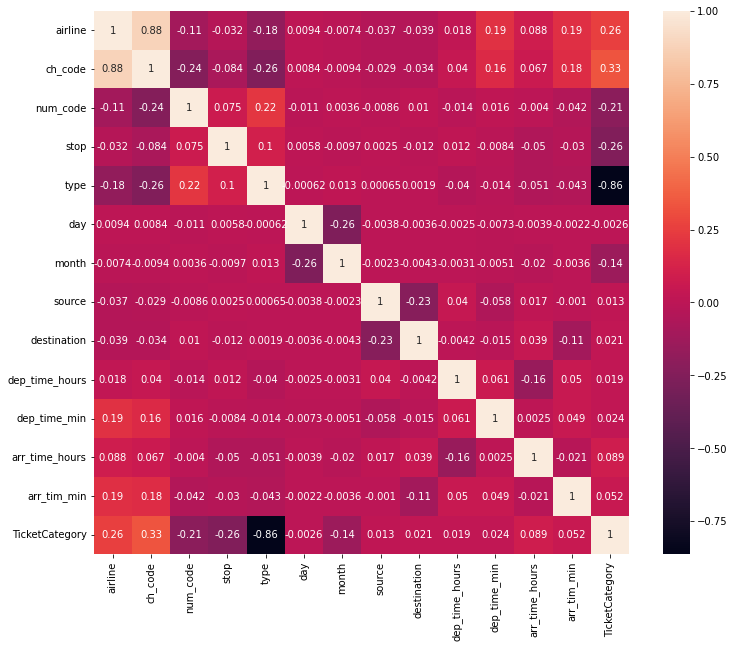

In [6]:
corr_data = pd.concat([X_train, y_train], axis=1)
corr = corr_data.corr()
top_feature = corr.index[abs(corr['TicketCategory'])>0.2][:-1]
fig, ax = plt.subplots(figsize=(12,10))
sns.heatmap(corr, annot=True)

In [7]:
#top_feature = ['airline', 'ch_code', 'num_code', 'stop', 'type']
top_feature = X_train.columns
X_train_fs, X_test_fs = X_train[top_feature], X_test[top_feature]
cat_cols = [col for col in X_train_fs.columns if X_train_fs[col].nunique() < 10]
#cat_cols = ['airline', 'ch_code', 'stop', 'type', 'month', 'source', 'destination']
cat_cols

['airline', 'ch_code', 'stop', 'type', 'month', 'source', 'destination']

In [8]:
SI = SimpleImputer(strategy='most_frequent')
SI.fit(X_train_fs[X_train_fs.columns])
X_train_fs[X_train_fs.columns] = SI.transform(X_train_fs[X_train_fs.columns])
X_test_fs[X_test_fs.columns] = SI.transform(X_test_fs[X_test_fs.columns])

In [9]:
X_train_fs2, X_test_fs2 = X_train_fs[cat_cols], X_test_fs[cat_cols]
X_train_fs.drop(columns=cat_cols, inplace=True)
X_test_fs.drop(columns=cat_cols, inplace=True)
# if error occurs, handle_unknown='error' instead of ignore
ohe = OneHotEncoder(handle_unknown='ignore', drop='first', dtype=np.int)
X_train_fs2 = ohe.fit_transform(X_train_fs2).toarray()
X_test_fs2 = ohe.transform(X_test_fs2).toarray()
X_train_fs = X_train_fs.to_numpy()
X_test_fs = X_test_fs.to_numpy()
X_train_fs = np.concatenate((X_train_fs, X_train_fs2), axis=1)
X_test_fs = np.concatenate((X_test_fs, X_test_fs2), axis=1)

In [10]:
SC = StandardScaler()
X_train_fs = SC.fit_transform(X_train_fs)
X_test_fs = SC.transform(X_test_fs)
y_train = np.expand_dims(y_train, axis=1)
y_test = np.expand_dims(y_test, axis=1)

In [11]:
scores = []
time_train = []
time_test = []
#Disable gpu if error occurs
for p1 in [25, 50, 75]:
    for p2 in [10, 25, 100]:
        start = time.time()
        clf = LGBMClassifier(num_leaves=p1, min_child_samples=p2, random_state=42, device='gpu')
        clf.fit(X_train_fs, y_train)
        end = time.time()
        time_train.append(end-start)
        start2 = time.time()
        y_pred = clf.predict(X_test_fs)
        end2 = time.time()
        time_test.append(end2-start2)
        scores.append(metrics.r2_score(y_test, y_pred))
        print(f'num_leaves={p1}, min_child_samples={p2},  score = {metrics.r2_score(y_test, y_pred)}, time = {end-start+end2-start2}')

num_leaves=25, min_child_samples=10,  score = 0.9381993954998894, time = 12.518309831619263
num_leaves=25, min_child_samples=25,  score = 0.9415898584105934, time = 12.117903470993042
num_leaves=25, min_child_samples=100,  score = 0.9415898584105934, time = 11.458448886871338
num_leaves=50, min_child_samples=10,  score = 0.954285258420674, time = 18.78034996986389
num_leaves=50, min_child_samples=25,  score = 0.9569411210340588, time = 18.760369300842285
num_leaves=50, min_child_samples=100,  score = 0.9547184842370418, time = 17.28960132598877
num_leaves=75, min_child_samples=10,  score = 0.9624788771215421, time = 27.10541605949402
num_leaves=75, min_child_samples=25,  score = 0.9624035335013043, time = 28.44829821586609
num_leaves=75, min_child_samples=100,  score = 0.9603880916599413, time = 27.29326057434082


In [12]:
scores2 = []
time_train2 = []
time_test2 = []
#Disable gpu if error occurs
for p1 in [0.01, 0.1, 0.3]:
    for p2 in [2, 5, 9]:
        start = time.time()
        clf = XGBClassifier(learning_rate=p1, max_depth=p2, random_state=42, tree_method='gpu_hist', gpu_id=0)
        clf.fit(X_train_fs, y_train)
        end = time.time()
        time_train2.append(end-start)
        start2 = time.time()
        y_pred = clf.predict(X_test_fs)
        end2 = time.time()
        time_test2.append(end2-start2)
        scores2.append(metrics.r2_score(y_test, y_pred))
        print(f'learning_rate={p1}, max_depth={p2},  score = {metrics.r2_score(y_test, y_pred)}, time = {end-start+end2-start2}')

learning_rate=0.01, max_depth=2,  score = 0.7166326442853812, time = 1.542722463607788
learning_rate=0.01, max_depth=5,  score = 0.8090039226970065, time = 1.79850172996521
learning_rate=0.01, max_depth=9,  score = 0.8706726758617008, time = 14.429028749465942
learning_rate=0.1, max_depth=2,  score = 0.8058018188368972, time = 1.4827635288238525
learning_rate=0.1, max_depth=5,  score = 0.8917877254333632, time = 2.9335548877716064
learning_rate=0.1, max_depth=9,  score = 0.9550198587179932, time = 14.160202264785767
learning_rate=0.3, max_depth=2,  score = 0.8624037135405949, time = 1.8024983406066895
learning_rate=0.3, max_depth=5,  score = 0.9463930142007575, time = 3.1773509979248047
learning_rate=0.3, max_depth=9,  score = 0.9734037020560329, time = 15.11141061782837


In [13]:
scores3 = []
time_train3 = []
time_test3 = []
for p1 in [50, 200, 450]:
    for p2 in [10, 50, 100]:
        start = time.time()
        clf = RandomForestClassifier(n_estimators=p1, max_features=p2, random_state=42)
        clf.fit(X_train_fs, y_train)
        end = time.time()
        time_train3.append(end-start)
        start2 = time.time()
        y_pred = clf.predict(X_test_fs)
        end2 = time.time()
        time_test3.append(end2-start2)
        scores3.append(metrics.r2_score(y_test, y_pred))
        print(f'n_estimator={p1}, max_features={p2},  score = {metrics.r2_score(y_test, y_pred)}, time = {end-start+end2-start2}')

n_estimator=50, max_features=10,  score = 0.9673008688167656, time = 12.877273082733154
n_estimator=50, max_features=50,  score = 0.9718591578411566, time = 32.1132435798645
n_estimator=50, max_features=100,  score = 0.9718591578411566, time = 31.33000087738037
n_estimator=200, max_features=10,  score = 0.9671690174813493, time = 46.121840953826904
n_estimator=200, max_features=50,  score = 0.9717461424107998, time = 87.47152876853943
n_estimator=200, max_features=100,  score = 0.9717461424107998, time = 103.85837030410767
n_estimator=450, max_features=10,  score = 0.9671690174813493, time = 75.07971477508545
n_estimator=450, max_features=50,  score = 0.9718591578411566, time = 197.50338006019592
n_estimator=450, max_features=100,  score = 0.9718591578411566, time = 197.49168968200684


In [21]:
xgbc = XGBClassifier(learning_rate= 0.3, max_depth= 9,  random_state=42, tree_method='gpu_hist', gpu_id=0)
xgbc.fit(X_train_fs, y_train)
print(f'XGBoost score = {metrics.r2_score(y_test, xgbc.predict(X_test_fs))}')

XGBoost score = 0.9734037020560329


In [22]:
lgbmc = LGBMClassifier(num_leaves=75, min_child_samples=10, random_state=42, device='gpu')
lgbmc.fit(X_train_fs, y_train)
print(f'LightGBM score = {metrics.r2_score(y_test, lgbmc.predict(X_test_fs))}')

LightGBM score = 0.9624788771215421


In [23]:
rfc = RandomForestClassifier(n_estimators=200, max_features=50, random_state=42)
rfc.fit(X_train_fs, y_train)
print(f'RandomForest score = {metrics.r2_score(y_test, rfc.predict(X_test_fs))}')

RandomForest score = 0.9717461424107998


In [24]:
df_tot = pd.DataFrame({'score_lgbm': scores, 'score_xgb': scores2, 'score_rf': scores3, 'time_train_lgbm': time_train, 'time_test_lgbm': time_test, 'time_train_xgb': time_train2, 'time_test_xgb': time_test2, 'time_train_rf': time_train3, 'time_test3_rf': time_test3})
df_tot.head(10)

,score_lgbm,score_xgb,score_rf,time_train_lgbm,time_test_lgbm,time_train_xgb,time_test_xgb,time_train_rf,time_test3_rf
0,0.938199,0.716633,0.967301,12.406402,0.111908,1.514746,0.027977,12.293756,0.583517
1,0.941590,0.809004,0.971859,11.986013,0.131890,1.746545,0.051957,31.689642,0.423602
2,0.941590,0.870673,0.971859,11.326558,0.131891,14.269164,0.159865,30.882374,0.447627
3,0.954285,0.805802,0.967169,18.632474,0.147876,1.430806,0.051957,44.749430,1.372411
4,0.956941,0.891788,0.971746,18.620486,0.139884,2.841632,0.091923,86.288481,1.183048
5,0.954718,0.955020,0.971746,17.149711,0.139890,14.016323,0.143880,102.571673,1.286697
6,0.962479,0.862404,0.967169,26.961537,0.143879,1.746544,0.055954,72.089712,2.990003
7,0.962404,0.946393,0.971859,28.304419,0.143880,3.081438,0.095913,194.861216,2.642164
8,0.960388,0.973404,0.971859,27.109413,0.183847,14.959537,0.151874,194.767798,2.723891


In [25]:
s_lgbm = 0.962479*100
tr_lgbm = 27.109413
tt_lgbm = 0.183847

s_rf = 0.971859*100
tr_rf = 194.767798
tt_rf = 2.723891

s_xgb = 0.973404*100
tr_xgb = 14.959537
tt_xgb = 0.151874

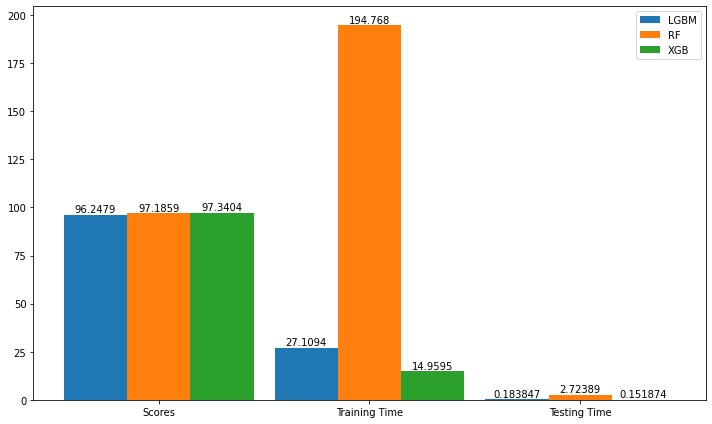

In [26]:
fig, ax = plt.subplots(figsize=(10, 6))
labels = ['Scores', 'Training Time', 'Testing Time']

xgb = [s_xgb, tr_xgb, tt_xgb]
lgbm = [s_lgbm, tr_lgbm, tt_lgbm]
rf = [s_rf, tr_rf, tt_rf]

x = np.arange(len(labels))
width = 0.3  # the width of the bars

rects1 = ax.bar(x - width, lgbm, width, label='LGBM')
rects2 = ax.bar(x , rf, width, label='RF')
rects3 = ax.bar(x + width, xgb, width, label='XGB')

ax.set_xticks(x, labels)
ax.legend()

ax.bar_label(rects1)
ax.bar_label(rects2)
ax.bar_label(rects3)

fig.tight_layout()
plt.show()


In [28]:
with open('labelencoder.pickle', 'wb') as handle:
    pickle.dump(le_dict, handle, protocol=pickle.HIGHEST_PROTOCOL)

pickle.dump(SC, open('scaler.pkl','wb'))
pickle.dump(ohe, open('onehotencoder.pkl','wb'))
pickle.dump(SI, open('simpleimputer.pkl','wb'))
pickle.dump(xgbc, open('xgb.pkl','wb'))
pickle.dump(lgbmc, open('lgbm.pkl','wb'))
pickle.dump(rfc, open('rf.pkl','wb'))